In [ ]:
import os
import numpy as np
from tqdm import tqdm

from trunk_sim.data import TrunkData
from trunk_sim.policy import HarmonicPolicy, RandomWalkPolicy, steady_state_input
from trunk_sim.rollout import rollout

# Util functions
from utils.plotting import plot_trajectories
from utils.ssm import DelaySSM
from utils.systems import Trunk

# Use JAX
import jax
import jax.numpy as jnp

In [2]:
# Instantiate Trunk simulator
trunk = Trunk()

INFO   2025-04-02 23:41:49 xla_bridge Unable to initialize backend 'cuda': 
INFO   2025-04-02 23:41:49 xla_bridge Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO   2025-04-02 23:41:49 xla_bridge Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


Number of autonomous data points:  20000


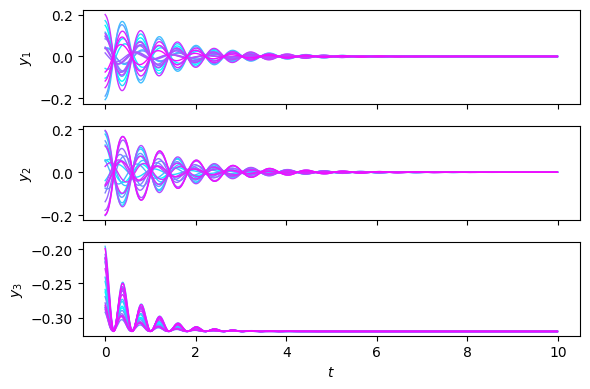

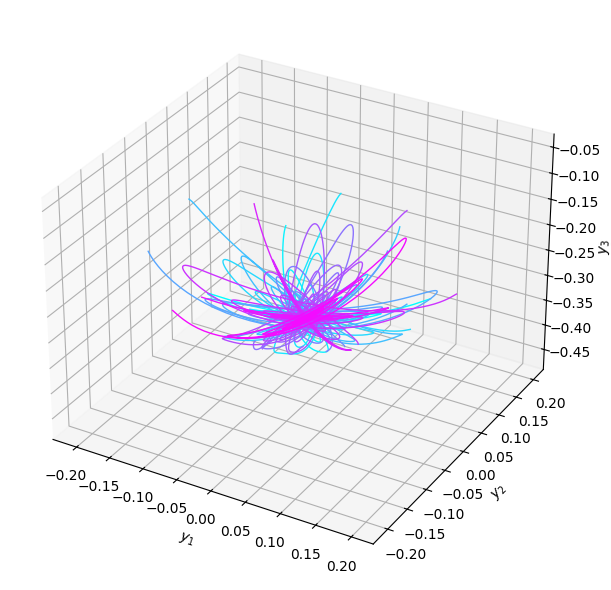

In [3]:
# Instantiate Trunk Data class
trunk_aut_data = TrunkData(
    trunk.num_links_per_segment,
    trunk.num_segments,
    states="pos_vel",
    segments="all",
)

# Collect autonomous Trunk data
def collect_data(system: Trunk,
                 data: TrunkData,
                 num_rollouts: int = 20,
                 policy: str = "none",
                 name: str = "autonomous_data"
                 ):
    if not os.path.exists(system.data_folder):
        os.makedirs(system.data_folder)

    if system.render_video and not os.path.exists(
        os.path.join(system.data_folder, "videos")
    ):
        os.makedirs(os.path.join(system.data_folder, "videos"))

    if policy == "harmonic":
        policy = HarmonicPolicy(
            frequency_range=[0.5, 5],
            amplitude_range=[0.5, 2.5],
            phase_range=[0, 2 * np.pi],
            num_segments=trunk.num_segments
        )
    elif policy == "random_walk":
        policy = RandomWalkPolicy()
    elif policy == "none":
        policy = None
    else:
        raise ValueError(f"Invalid policy: {policy}")
    
    for rollout_idx in tqdm(range(num_rollouts)):

        if system.init_steady_state:
            angle = np.random.uniform(0,2*np.pi)
            sign = np.random.choice([-1,1])
            system.simulator.set_initial_steady_state(
                steady_state_input(system.simulator.num_segments, amplitude=np.random.uniform(0.0, 15.0), angle=angle),
                kick=steady_state_input(system.simulator.num_segments, amplitude=np.random.uniform(5.0, 12.5), angle=angle + np.pi/2 * sign),
                kick_duration=0.5,
            )

        rollout(
            simulator=system.simulator,
            policy=policy,
            data=data,
            duration=system.duration,
            render_video=system.render_video,
            video_filename=os.path.join(
                system.data_folder, "videos", f"rollout_{rollout_idx}.mp4"
            ),
            stop_at_convergence=system.stop_at_convergence,
            traj_ID = rollout_idx
        )

    data.save_to_csv(os.path.join(system.data_folder, name + ".csv"))

COLLECT = False
if COLLECT:
    collect_data(trunk, trunk_aut_data)
else:
    trunk_aut_data.load_from_csv(os.path.join(trunk.data_folder, "autonomous_data.csv"))
print("Number of autonomous data points: ", len(trunk_aut_data))

# Extract arrays
tss, aut_trajs, _, _ = trunk_aut_data.convert_to_arrays()

# Visualize tip trajectories
# %matplotlib ipympl
plot_trajectories(aut_trajs[:, 12:15], tss[0])

# Learn autonomous SSM with delay embeddings

In [4]:
N_aut_train = 10
tip_positions = jnp.array(aut_trajs[:N_aut_train, 12:15])
tip_velocities = jnp.array(aut_trajs[:N_aut_train, 15:18])
aut_trajs_obs = tip_positions
ts = tss[0]

# Center the Z coordinate
aut_trajs_obs = aut_trajs_obs.at[:, 2].set(aut_trajs_obs[:, 2] - jnp.mean(aut_trajs_obs[:, 2, -1]))

i_trunc = 0
delay_ssm = DelaySSM(aut_trajs_obs=aut_trajs_obs[:, :, i_trunc:],
                     SSMDim=5,
                     SSMOrder=2,
                     ROMOrder=2,
                     N_delay=3,
                     N_obs_delay=3,
                     orthogonalize=True,
                     ts=ts[i_trunc:])

INFO   2025-04-02 23:41:50 ridge Transforming data
INFO   2025-04-02 23:41:50 ridge Skipping CV on ridge regression
INFO   2025-04-02 23:41:50 ridge Fitting regression model
INFO   2025-04-02 23:41:51 ridge Transforming data
INFO   2025-04-02 23:41:51 ridge Skipping CV on ridge regression
INFO   2025-04-02 23:41:51 ridge Fitting regression model
INFO   2025-04-02 23:41:51 ridge Transforming data
INFO   2025-04-02 23:41:51 ridge Skipping CV on ridge regression
INFO   2025-04-02 23:41:51 ridge Fitting regression model
INFO   2025-04-02 23:41:51 ridge Transforming data
INFO   2025-04-02 23:41:51 ridge Skipping CV on ridge regression
INFO   2025-04-02 23:41:51 ridge Fitting regression model


# Simulate controlled system
Two control inputs per joint that decompose into torque and force along the pendulum.

Number of controlled data points:  30000


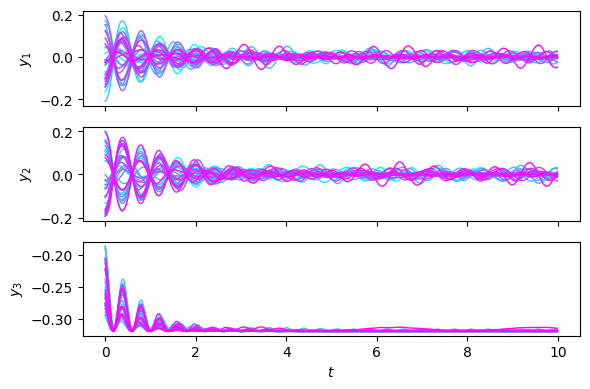

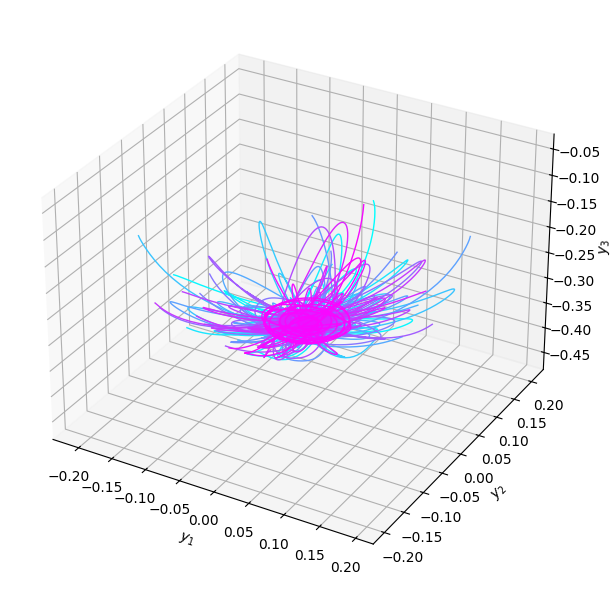

In [5]:
# Instantiate Trunk Data class
trunk_ctrl_data = TrunkData(
    trunk.num_links_per_segment,
    trunk.num_segments,
    states="pos_vel",
    segments="all",
)

COLLECT = False
if COLLECT:
    collect_data(trunk, trunk_ctrl_data, num_rollouts=30, policy="harmonic", name="controlled_data")
else:
    trunk_ctrl_data.load_from_csv(os.path.join(trunk.data_folder, "controlled_data.csv"))
print("Number of controlled data points: ", len(trunk_ctrl_data))

# Extract arrays
tss, ctrl_trajs, control_inputs, _ = trunk_ctrl_data.convert_to_arrays()

# Visualize tip trajectories
# %matplotlib ipympl
plot_trajectories(ctrl_trajs[:, 12:15], tss[0])

In [6]:
N_ctrl_train = 20
ctrl_tip_positions = jnp.array(ctrl_trajs[:N_ctrl_train, 12:15])
ctrl_tip_velocities = jnp.array(ctrl_trajs[:N_ctrl_train, 15:18])
ctrl_trajs_obs = ctrl_tip_positions
us = control_inputs[:N_ctrl_train]
ts = tss[0]

# Center the Z coordinate
ctrl_trajs_obs = ctrl_trajs_obs.at[:, 2].set(ctrl_trajs_obs[:, 2] - jnp.mean(ctrl_trajs_obs[:, 2, -1]))

# Fit B_r

In [7]:
from utils.models import SSMR, get_residual_labels
from utils.residual import ResidualBr, PolyBr

# Obtain labels used to fit B_r
xs_flat, us_flat, delta_x_dots_flat = get_residual_labels(delay_ssm, ctrl_trajs_obs, ts, us=us)

poly_B_r = PolyBr(5, 6, 0, 0.0)
poly_B_r.fit(xs_flat, us_flat, delta_x_dots_flat)
residual_B_r = ResidualBr(poly_B_r)
obs_perf_matrix = jnp.zeros((3, (delay_ssm.N_obs_delay + 1) * 3))
obs_perf_matrix = obs_perf_matrix.at[:, 0:3].set(jnp.eye(3))
poly_ssmr = SSMR(delay_ssm, residual_B_r, obs_perf_matrix)

# Run MPC

In [37]:
from utils.mpc import generate_ref_trajectory
from utils.gusto import GuSTOConfig

# Create MPC problem
dt = 0.01
T_f = 2.5
t_mpc = jnp.arange(0, T_f+dt, dt)

# Generate reference trajectory
z_ref = generate_ref_trajectory(t_mpc, type='circle', T=T_f, A=0.2, dim=3)

R = 0.000000001 * jnp.eye(poly_ssmr.n_u)
R_du = 0.00001 * jnp.eye(poly_ssmr.n_u)

Q = jnp.eye(poly_ssmr.n_z)
Q = Q.at[2, 2].set(0.0)
gusto_config = GuSTOConfig(
    Qz=Q,
    Qzf=Q,
    R=R,
    R_du=R_du,
    x_char=jnp.ones(poly_ssmr.n_x),
    f_char=jnp.ones(poly_ssmr.n_x),
    N=8,
    dt=dt
)

In [38]:
from utils.mpc import run_mpc
from utils.misc import HyperRectangle

# Solve MPC problem
U = HyperRectangle([20.0] * 6, [-20.0] * 6)
dU = None
x_mpc, z_mpc, u_mpc, z_true, xf_true, _, _ = run_mpc(
    trunk,
    poly_ssmr,
    gusto_config,
    z_ref,
    None,
    U=U,
    dU=dU,
    N_exec=2)

First solve may take a while due to factorization and caching.
Solved in 2 iterations/15.621 seconds, with 0.003 s from LOCP solve


  0%|          | 0/242 [00:00<?, ?it/s]

Solved in 2 iterations/0.025 seconds, with 0.002 s from LOCP solve
Solved in 1 iterations/0.013 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.013 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.013 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.632 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.002 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.009 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.010 seconds, with 0.001 s from LOCP solve
Solved in 1 iterations/0.011 seconds, with 0.001 s from LOCP s

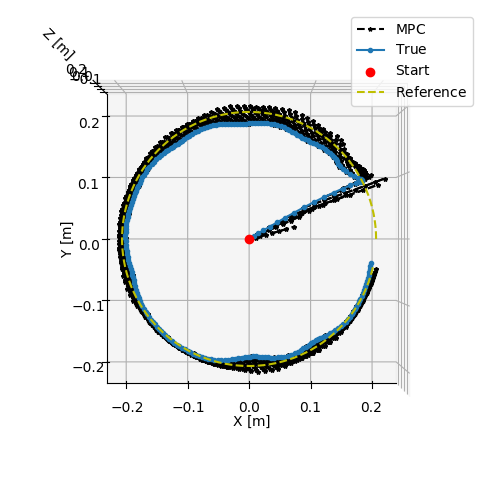

In [39]:
import matplotlib.pyplot as plt
from utils.plotting import plot_mpc_trajectory

# plt.close('all')
plot_mpc_trajectory(t_mpc, z_ref, z_mpc, z_true, u_mpc, gusto_config.N, plot_controls=False, top_down=True)

In [40]:
# Compute integrated squared error
def compute_ise(i_start, i_end, z_ref, z_true, dim=2):
    if dim == 2:
        return jnp.sum((jnp.linalg.norm(z_true[i_start:i_end, :2] - z_ref[i_start:i_end, :2], axis=1)) ** 2 * 0.01)
    elif dim == 3:
        return jnp.sum((jnp.linalg.norm(z_true[i_start:i_end, :3] - z_ref[i_start:i_end, :3], axis=1)) ** 2 * 0.01)
ise = compute_ise(15, -gusto_config.N, z_ref, z_true)
# ise = compute_ise(0, -gusto_config.N, z_ref, z_true)
print("ISE: ", ise*10**4, "cm^2")

ISE:  4.7008133 cm^2


In [ ]:
# np.savez('data/results/mpc_figure_eight_orth.npz', t_mpc=t_mpc, z_ref=z_ref, z_mpc=z_mpc, z_true=z_true, u_mpc=u_mpc, ise=ise)

(-0.22000000327825547,
 0.22000000327825547,
 -0.21998262852430345,
 0.21998262852430345)

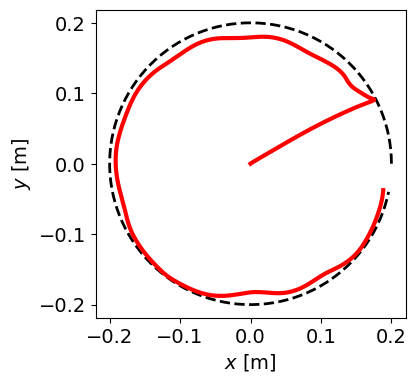

In [ ]:
fig = plt.figure(figsize=(4, 4))
# Plot the true trajectory, start point, and reference
plt.plot(z_ref[:-gusto_config.N, 0], z_ref[:-gusto_config.N, 1], linestyle='--', linewidth=2, color='black')
plt.plot(z_true[:-gusto_config.N, 0], z_true[:-gusto_config.N, 1], linestyle='-', linewidth=3, color='red')
plt.xlabel(r'$x$ [m]', fontsize=14)
plt.ylabel(r'$y$ [m]', fontsize=14)
x_ticks = np.linspace(-0.2, 0.2, num=5)
y_ticks = np.linspace(-0.2, 0.2, num=5)
plt.xticks(x_ticks, fontsize=14)
plt.yticks(y_ticks, fontsize=14)
plt.axis('equal')